## Supervised Learning Workshop
In this workshop, we are going to train a model to predict the numerical values of hand-written digits using supervised learning.

## Part 0: Setup

#### Installs

In [1]:
# pip install seaborn
# pip install numpy==1.23.5
# pip install scikit-learn
# python version: 3.9.6
# pip install gymnasium
# pip install "gymnasium[toy-text]"

#### Imports

In [2]:
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt

from typing import List

from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

#### Helper Functions

In [3]:
"""
Shows the distribution of data in array data. Data must be an array of integers.
"""
def distributionOfData(data):
    # Define bins
    bin_edges = np.arange(0, 11, 1)  # Bin edges at integer intervals (-4 to 4)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

    # Create the histogram
    plt.hist(data, bins=bin_edges, color='blue', edgecolor='black', alpha=0.7, label="Data Distribution")

    # Add labels and title
    plt.xlabel('Value Ranges (Standard Deviations)', fontsize=12)
    plt.ylabel('Frequency (Count of Data Points)', fontsize=12)
    plt.title('Histogram of Randomly Generated Data', fontsize=14)

    # Set x-axis ticks at bin centers
    plt.xticks(bin_centers, labels=[f"{x}" for x in bin_edges[:-1]])

    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

"""
Shows the images of digits used in the data set.
"""
def showVisualDigitsData(X_data, y_data, digit=0):
    # Print data
    print("Example of Data:")

    indices_less_than_max = np.where(y_data == digit)

    plt.imshow(X_data[indices_less_than_max][0].reshape(8, 8), cmap="gray")
    plt.title(f"Example Image (Label: {y_data[indices_less_than_max][0]})")
    plt.show()

"""
Shows numerical representation of each digit. Each digit is represented as a len-64 array with each value ranging between 0 an 16 where 0
correlates to black and 16 correlates to white.
"""
def showNumericalDigitsData(X_data, y_data):
    for i in range(3):
        print(f"Y-value: {X_data[i]}")
        print(f"X-Value: {y_data.data[i]}\n")

"""
Filters the dataset to include digits < max_val
"""
def filteredDigits(sample_fraction=0.2):
    digits = load_digits()
    y = digits.target
    
    # Find indices where labels are even
    even_indices = np.where(y % 2 == 0)[0]
    
    # Find indices where labels are odd
    odd_indices = np.where(y % 2 == 1)[0]
    
    # Select 20% of each odd digit class
    selected_odd_indices = []
    for odd_digit in np.unique(y[odd_indices]):
        digit_indices = np.where(y == odd_digit)[0]
        sample_size = max(1, int(len(digit_indices) * sample_fraction))
        selected_odd_indices.extend(np.random.choice(digit_indices, size=sample_size, replace=False))
    
    # Combine even indices with selected odd indices
    selected_indices = np.concatenate([even_indices, selected_odd_indices])
    
    return digits.data[selected_indices], digits.target[selected_indices]

"""
Gets all the digits.
"""
def allDigits():
    digits = load_digits()
    return digits.data, digits.target

"""
Creates the supervised model. no-print means no statistics for each epoch will be printed
"""
def supervisedModel(X_train, X_test, y_test, y_train, epochs=10, batch_size=64, no_print=False):
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    # Scale data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define MLP model (warm_start=True allows incremental training)
    model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1, warm_start=True, verbose=False, batch_size=batch_size)

    # Lists to store accuracy values
    train_accuracies = []
    test_accuracies = []
    epoch_times = []  # List to store epoch times

    # Training loop
    for epoch in range(epochs):
        start_time = time.time()  # Start time of the epoch

        model.fit(X_train, y_train)
        
        train_acc = accuracy_score(y_train, model.predict(X_train))
        test_acc = accuracy_score(y_test, model.predict(X_test))
        
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        if not (no_print):
            print(f"Epoch {epoch+1}/{epochs} - Training Accuracy: {train_acc:.4f}, Testing Accuracy: {test_acc:.4f}")
        end_time = time.time()  # End time of the epoch
        epoch_time = end_time - start_time  # Time taken for the epoch
        epoch_times.append(epoch_time)  # Store epoch time
    return model, train_accuracies, test_accuracies, epoch_times

"""
Generate first round data
"""
def firstRoundData():
    X_data, y_data = filteredDigits()
    X_train, _, y_train, _ = train_test_split(X_data, y_data, test_size=0.2)
    X_test, y_test = allDigits()
    return X_train, X_test, y_train, y_test

"""
Graphs test vs training loss.
"""
def graphAccuracies(train_accuracies, test_accuracies):
    epochs = range(1, len(train_accuracies) + 1)  # Create an epoch range
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accuracies, label="Training Accuracy", marker='o')
    plt.plot(epochs, test_accuracies, label="Testing Accuracy", marker='s')
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Testing Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

"""
Shows images of the correctly predicted digits.
"""
def showCorrectPredictions(model, X_test, y_test):
    model_preds = model.predict(X_test)
    correct_indices = np.where(model_preds == y_test)[0][:10]  # Select 10 correctly classified digits

    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X_test[correct_indices[i]].reshape(8, 8), cmap='gray')
        ax.set_title(f"Pred: {model_preds[correct_indices[i]]}, True: {y_test[correct_indices[i]]}")
        ax.axis('off')
    plt.show()

"""
Shows images of the incorrectly predicted digits.
"""
def showIncorrectPredictions(model, X_test, y_test):
    model_preds = model.predict(X_test)
    incorrect_indices = np.where(model_preds != y_test)[0][:10]  # Select 10 correctly classified digits

    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X_test[incorrect_indices[i]].reshape(8, 8), cmap='gray')
        ax.set_title(f"Pred: {model_preds[incorrect_indices[i]]}, True: {y_test[incorrect_indices[i]]}")
        ax.axis('off')
    plt.show()

"""
Creates feature importance graph.
"""
def showFeatureImportance(model, X_test, y_test):
    
    # Assuming 'model' is your trained MLPClassifier model
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    # Get the feature importances
    importances = result.importances_mean

    norm_importances = (importances - np.min(importances)) / (np.max(importances) - np.min(importances))

    importance_matrix = norm_importances.reshape(8, 8)
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(importance_matrix, cmap='Blues')  # Using the Blues colormap

    # Add colorbar to the plot
    fig.colorbar(cax)

    # Set axis labels (just for clarity, with indices 1 to 8 for both X and Y)
    ax.set_xticks(np.arange(8))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(np.arange(1, 9))
    ax.set_yticklabels(np.arange(1, 9))

    # Set title
    ax.set_title("Feature Importance Heatmap (Permutation Importance)")

    # Show the plot
    plt.show()

"""
Compares the average time per epoch, the max train accuracy, and the max test accuracy across many batch sizes.
"""
def compareBatchSizes(X_train, X_test, y_test, y_train, batch_sizes: List[int]):
    epoch_times_list = []
    total_times_list = []
    train_accuracies_list = []
    test_accuracies_list = []
    idx = []
    
    for batch_size in batch_sizes:
        _, train_accuracies, test_accuracies, epoch_times = supervisedModel(X_train, X_test, y_test, y_train, epochs=10, batch_size=batch_size, no_print=True)
        epoch_times_list.append(sum(epoch_times)/len(epoch_times))
        total_times_list.append(sum(epoch_times))
        test_accuracies_list.append(max(test_accuracies))
        train_accuracies_list.append(max(train_accuracies))
        idx.append(batch_size)

    createPlot(idx, epoch_times_list, "# Batches", "Time (sec)", "Average Training Time per Batch #")
    createPlot(idx, train_accuracies_list, "# Batches", "Max Train Accuracy", "Max Train Accuracy per Batch #")
    createPlot(idx, test_accuracies_list, "# Batches", "Max Test Accuracy", "Max Test Accuracy per Batch #")
    createPlot(idx, total_times_list, "# Batches", "Total Training Time (sec)", "Total Training Time per Batch #")

"""
Helper function to create plots.
"""
def createPlot(x, y, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
        

## Part 1: Preparing Data

The first step for the model training process is to gather the data. Run the cell below to get the x and y data.

In [4]:
X_train, X_test, y_train, y_test = firstRoundData()

Before proceeding, let's peek at the data. Run the function below to see the x and y data. Feel free to change the digit variable to see the example images of each digit.

Example of Data:


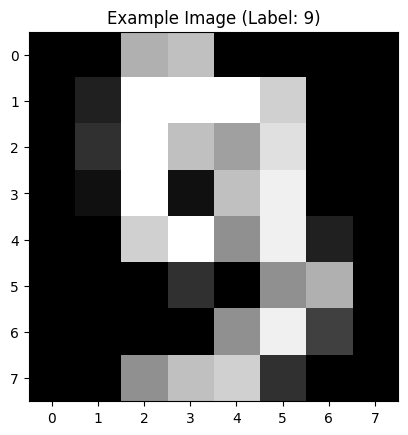

In [5]:
### Your code
digit = 9
showVisualDigitsData(X_test, y_test, digit)

It is important to remember that at the core, models are a series of mathematical functions. Because of this, the data input into the model must be numerical. Please write code to see how the images are converted from a visual to numerical representation. Hint: use the showNumericalDigitsData function

In [6]:
### Your code
showNumericalDigitsData(X_train, y_train)

Y-value: [ 0.  0.  3. 13. 16.  7.  0.  0.  0.  1. 12. 16.  8.  0.  0.  0.  0.  2.
 16.  8.  0.  0.  0.  0.  0.  8. 16.  4.  0.  0.  0.  0.  0.  9. 16. 10.
 11.  4.  0.  0.  0.  6. 16. 14. 13. 16.  3.  0.  0.  1. 11. 11.  2. 14.
 10.  0.  0.  0.  2. 15. 16. 15.  6.  0.]
X-Value: 6

Y-value: [ 0.  0.  0.  9. 13.  0.  0.  0.  0.  0.  3. 15.  6. 12.  0.  0.  0.  1.
 12.  8.  5. 14.  0.  0.  0.  6. 14.  0. 12.  7.  0.  0.  0. 14.  6.  2.
 16.  9.  5.  0.  0. 16. 13. 13. 16. 15.  4.  0.  1. 15. 16. 16. 12.  2.
  0.  0.  0.  3.  3. 13.  4.  0.  0.  0.]
X-Value: 4

Y-value: [ 0.  3. 15. 16.  8.  0.  0.  0.  0.  9. 16. 11. 15.  2.  0.  0.  0. 11.
 10.  4. 16.  2.  0.  0.  0.  2.  4.  6. 16.  1.  0.  0.  0.  0.  0. 10.
 13.  0.  0.  0.  0.  0.  2. 14. 13.  0.  0.  0.  0.  3. 16. 16. 16. 16.
 13.  1.  0.  3. 16. 12.  8. 12. 11.  1.]
X-Value: 2



How are the images converted to a numerical representation? Hint: Each number describes a pixel on the image.

## Part 2: Training Supervised Model

Run the code below to train the model. Peek at the supervisedModel function to see what model we use and how we train the model. What model do we use?

In [7]:
model, train_accuracies, test_accuracies, epoch_times= supervisedModel(X_train, X_test, y_test, y_train, epochs=10, batch_size=500)

Epoch 1/10 - Training Accuracy: 0.0993, Testing Accuracy: 0.1018
Epoch 2/10 - Training Accuracy: 0.2629, Testing Accuracy: 0.1809
Epoch 3/10 - Training Accuracy: 0.5035, Testing Accuracy: 0.3083
Epoch 4/10 - Training Accuracy: 0.6671, Testing Accuracy: 0.4029
Epoch 5/10 - Training Accuracy: 0.7301, Testing Accuracy: 0.4368
Epoch 6/10 - Training Accuracy: 0.7617, Testing Accuracy: 0.4558
Epoch 7/10 - Training Accuracy: 0.7815, Testing Accuracy: 0.4691
Epoch 8/10 - Training Accuracy: 0.7956, Testing Accuracy: 0.4775
Epoch 9/10 - Training Accuracy: 0.8072, Testing Accuracy: 0.4886
Epoch 10/10 - Training Accuracy: 0.8166, Testing Accuracy: 0.4992


Now that the model has trained, let's look into the results.

Run the function below to see what the model's testing and training accuracies are.

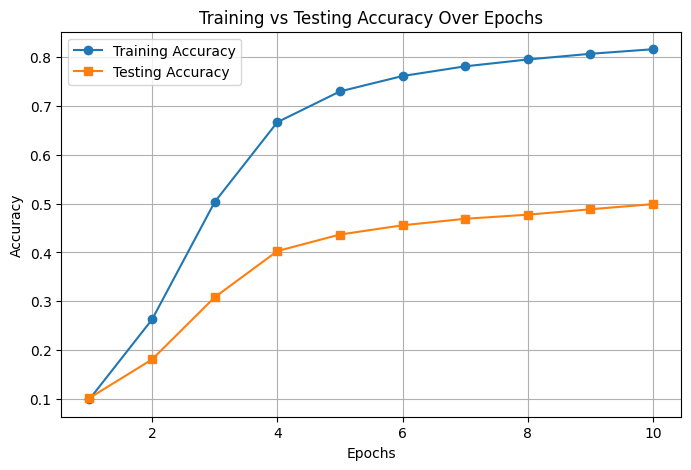

In [8]:
graphAccuracies(train_accuracies, test_accuracies)

It seems that the model is not performing well? Why do you we think this is the case? Let's debug by looking at the training and testing data distribution

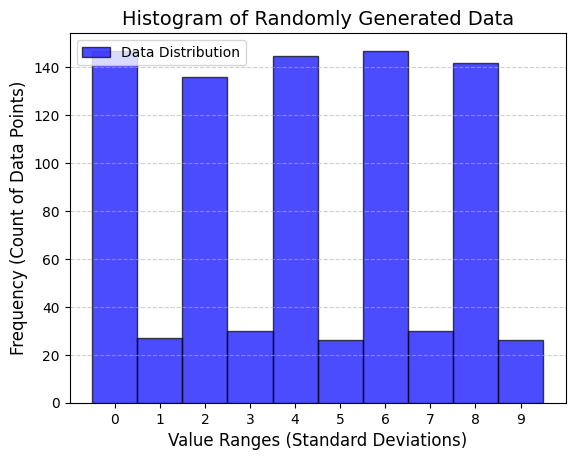

In [9]:
distributionOfData(y_train)

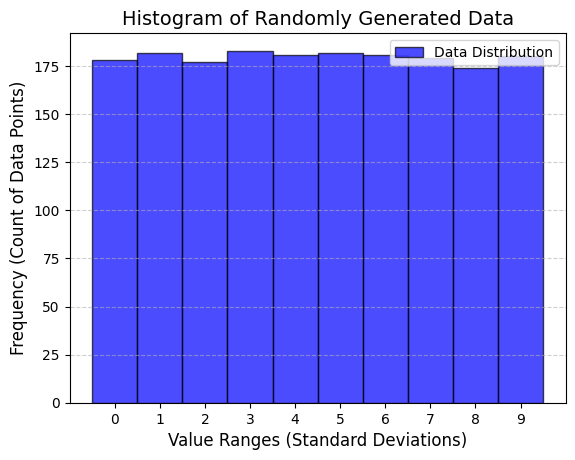

In [10]:
### Show the distribution of the testing data now
distributionOfData(y_test)

What is the issue? Why is it causing the model to perform badly?

Now that we know the issue, let's fix the data. Ensure to do a 80/20 split of the testing and training data and use the allDigits() function. Look into the firstRoundData function for guidance. Make sure to check the data again by plotting the distribution.

In [11]:
### Your code
X_data_updated, y_data_updated = allDigits()
X_train_updated, X_test_updated, y_train_updated, y_test_updated = train_test_split(X_data_updated, y_data_updated, test_size=0.2, random_state=42)

print(f"Length of training data: {len(X_train_updated)}")
print(f"Length of testing data: {len(X_test_updated)}")

Length of training data: 1437
Length of testing data: 360


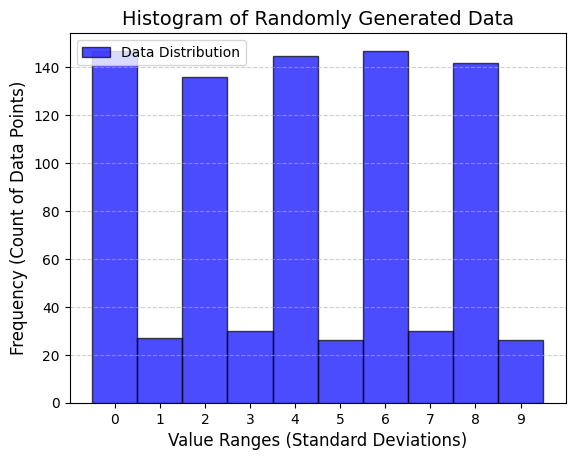

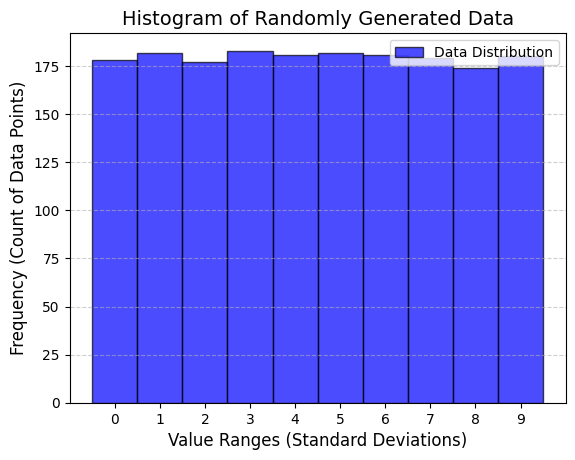

In [12]:
distributionOfData(y_train)
distributionOfData(y_test)

Why do we need the testing/training data split?

Now, following similar steps to above, train the model and plot the testing and training accuracies against each other

Epoch 1/10 - Training Accuracy: 0.2624, Testing Accuracy: 0.2306
Epoch 2/10 - Training Accuracy: 0.4669, Testing Accuracy: 0.4194
Epoch 3/10 - Training Accuracy: 0.6597, Testing Accuracy: 0.6194
Epoch 4/10 - Training Accuracy: 0.7627, Testing Accuracy: 0.7111
Epoch 5/10 - Training Accuracy: 0.8295, Testing Accuracy: 0.7972
Epoch 6/10 - Training Accuracy: 0.8775, Testing Accuracy: 0.8556
Epoch 7/10 - Training Accuracy: 0.9005, Testing Accuracy: 0.8722
Epoch 8/10 - Training Accuracy: 0.9193, Testing Accuracy: 0.8972
Epoch 9/10 - Training Accuracy: 0.9311, Testing Accuracy: 0.9111
Epoch 10/10 - Training Accuracy: 0.9402, Testing Accuracy: 0.9222


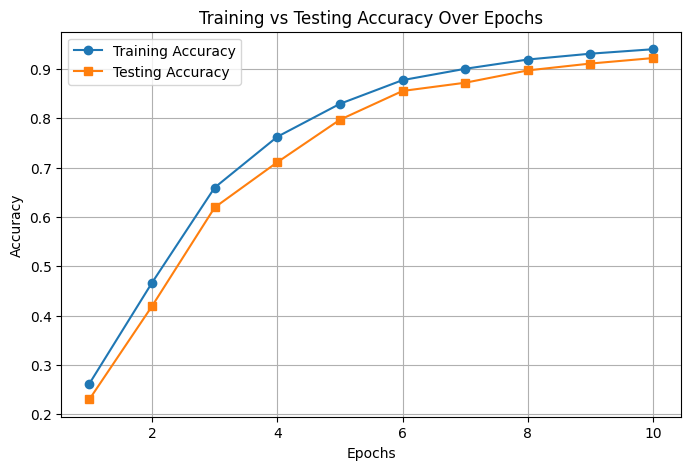

In [13]:
### Your code
model, train_accuracies, test_accuracies, epoch_times= supervisedModel(X_train_updated, X_test_updated, y_test_updated, y_train_updated, epochs=10, batch_size=500)
graphAccuracies(train_accuracies, test_accuracies)

How is the model performing now?

## Analyze Model Performance

#### Deep dive into the results

Fill in the below functions to see the correct and incorrect predictions that the model makes.

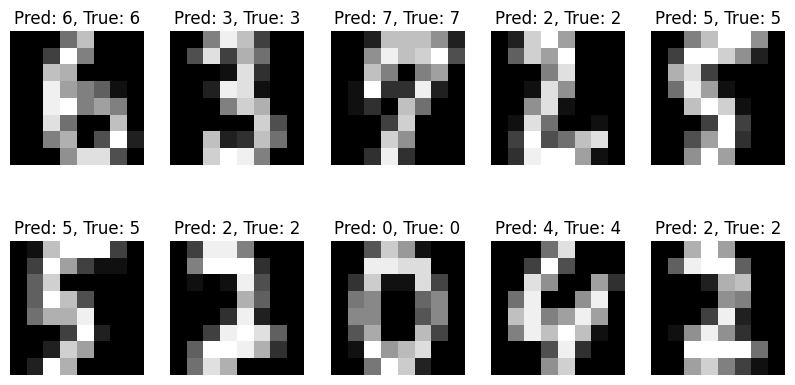

In [14]:
### Fill in functions appropriately 
showCorrectPredictions(model, X_test_updated, y_test_updated)

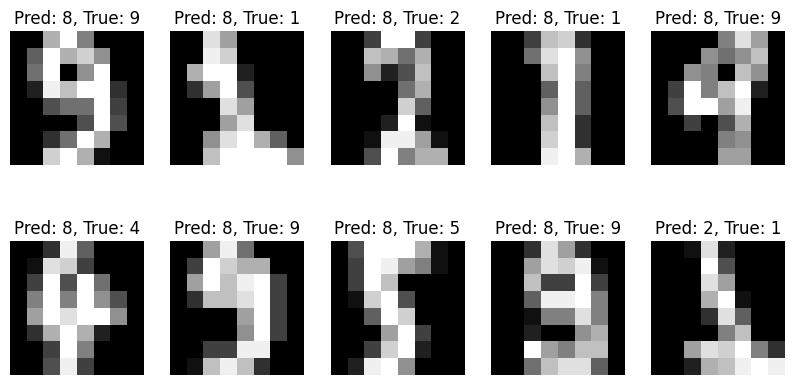

In [15]:
### Fill in functions appropriately 
showIncorrectPredictions(model, X_test_updated, y_test_updated)

Let's also peek into the feature importance. This will show us how much importance the model places on each pixel. 

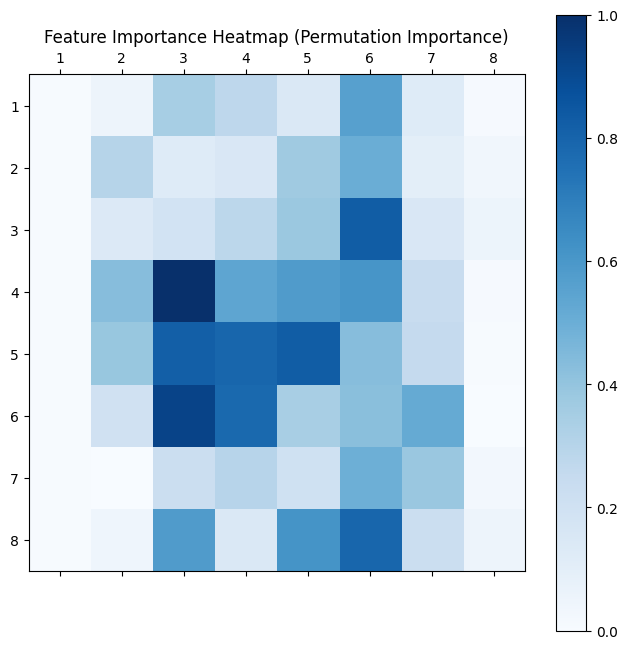

In [16]:
### Fill in functions appropriately 
showFeatureImportance(model, X_test_updated, y_test_updated)

Why do you think some pixels have more importance than others?

Analyze the results. How is the model performing? Are the incorrect predictions blatantly incorrect, or are they reasonable mistakes? What are some ways we can make the model perform even better?

Your turn: Try different batch sizes. Use the compareBatchSizes() function to see how batch size affects model performance (latency and accuracy)

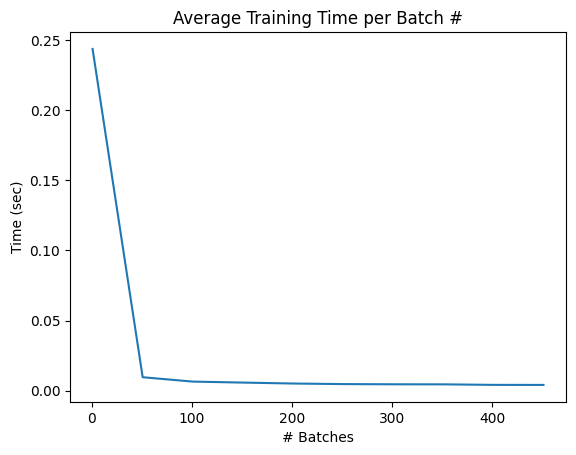

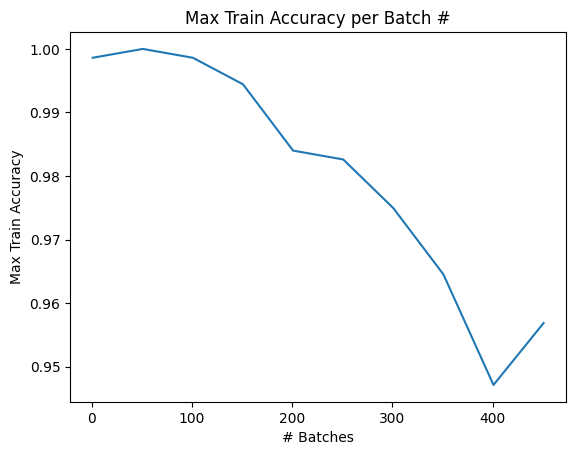

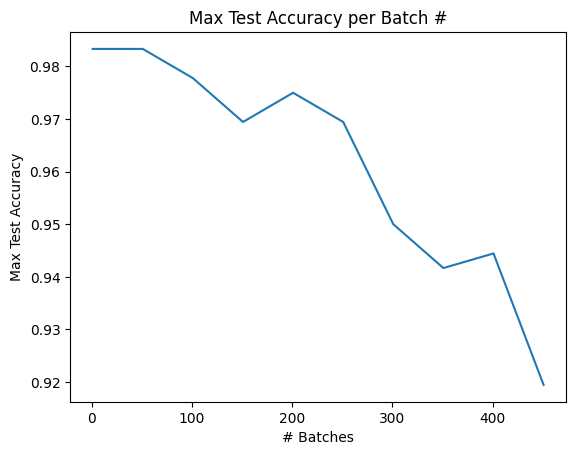

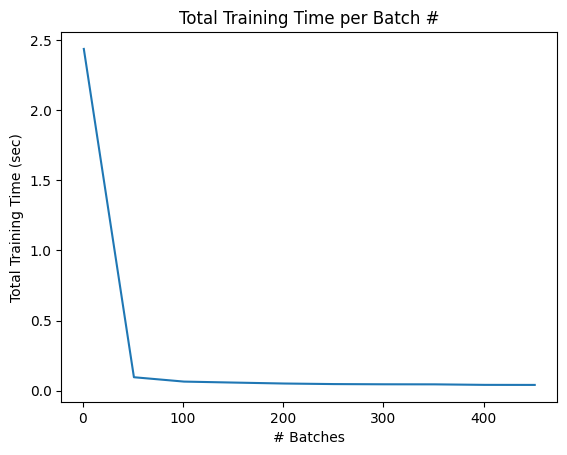

In [17]:
### Fill in function
compareBatchSizes(X_train_updated, X_test_updated, y_test_updated, y_train_updated, range(1, 500, 50))

What seems to be the optimal batch size? What parameters are you optimizing on (latency vs accuracy)?